# Prae-1b transit modelling with tight logg prior

Prae-1 transit modelling assuming a Normal prior on logg with $\mu=4.81$, and $\sigma=0.08$.

In [1]:
%pylab inline
sys.path.append('../src')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tqdm import tqdm
from core import *

## Run DE and MCMC

The Differential Evolution optimization takes $\sim$30 seconds, and the MCMC sampling $\sim$25 minutes. Comment out the `do_mcmc = False` line to run the MCMC sampling.

In [3]:
npop, de_iter, mc_iter = 100, 200, 40000
lpf = LPFunction(logg_prior = NP(4.81, 0.08, 'logg', lims=(1,10)))
de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)
sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf)

In [4]:
do_mcmc = True
do_mcmc = False

if do_mcmc:
    for r in tqdm(de(de_iter), total=de_iter): pass

    for i,r in enumerate(tqdm(sampler.sample(de.population, iterations=mc_iter, thin=100), total=mc_iter)):
        if ((i > 0) and (i%500 == 0)) or (i == mc_iter-1):
            savez('../results/02c', chains=sampler.chain)
            
chain = load('../results/02c.npz')['chains']
fc = chain[:,50:,:].reshape([-1,lpf.ps.ndim])
mp = median(fc, 0)

## Create the dataframe

In [5]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=lpf.ps.names)
df['tcc'] = df.tc - floor(df.tc.mean())
df['pc'] = df.p - 10
df['ecc'] = df.secw**2+df.sesw**2
df['w'] = arctan2(df.sesw, df.secw)/pi
df['e'] *= 1e6
df['k'] = sqrt(df.k2)
df['a'] = as_from_rhop(df.rho, df.p)
df['I'] = np.rad2deg(arccos(df.b/df.a))
df['u'] = 2*sqrt(df.q1)*df.q2
df['v'] = sqrt(df.q1)*(1-2*df.q2)
df['T14'] = 24*T14(df.p, df.a, df.k, radians(df.I))
df = df.drop(['k2','q1','q2'], axis=1)
df.describe()

,tc,p,rho,b,secw,sesw,e,c,tcc,pc,ecc,w,k,a,I,u,v,T14
count,35000.0000,35000.0000,35000.0000,3.5000e+04,35000.0000,35000.0000,35000.0000,3.5000e+04,35000.0000,35000.0000,3.5000e+04,35000.0000,35000.0000,35000.0000,35000.0000,35000.0000,35000.0000,35000.0000
mean,2317.8786,10.1344,7.7613,3.7862e-01,0.0006,-0.4536,936.7498,1.0001e+00,0.8786,0.1344,4.1478e-01,-0.4866,0.0769,34.6650,89.3723,0.9848,-0.2197,2.1732
std,0.0016,0.0004,1.4569,2.5292e-01,0.4185,0.1841,26.1728,3.7610e-05,0.0016,0.0004,2.2583e-01,0.2638,0.0067,2.1489,0.4224,0.3812,0.3548,0.2935
min,2317.8712,10.1325,3.4097,4.6983e-05,-0.7919,-0.8000,843.2496,9.9997e-01,0.8712,0.1325,7.7235e-05,-0.9999,0.0613,26.4545,88.1477,0.0002,-0.9860,1.3501
25%,2317.8776,10.1341,6.7322,1.5820e-01,-0.3544,-0.5858,918.9554,1.0001e+00,0.8776,0.1341,2.2780e-01,-0.7158,0.0726,33.1871,89.0456,0.7295,-0.4793,1.9988
50%,2317.8786,10.1344,7.6071,3.4375e-01,0.0033,-0.4493,936.0229,1.0001e+00,0.8786,0.1344,3.8820e-01,-0.4908,0.0754,34.5664,89.4323,0.9931,-0.2684,2.2309
75%,2317.8796,10.1347,8.6481,5.8055e-01,0.3576,-0.3342,953.8679,1.0002e+00,0.8796,0.1347,5.9352e-01,-0.2770,0.0794,36.0764,89.7378,1.2534,0.0004,2.3860
max,2317.8853,10.1363,14.8600,9.3446e-01,0.7996,0.3223,1066.5090,1.0003e+00,0.8853,0.1363,9.5358e-01,1.0000,0.1082,43.2076,89.9999,1.9842,0.9939,2.9907


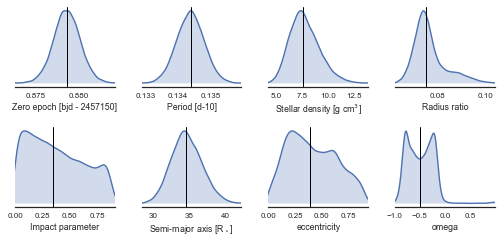

In [8]:
sb.set_context('paper')
fig, axs = subplots(2,4, figsize=(AAPGW, AAOCW))

pars = 'tcc pc rho k b a ecc w'.split()
labels = ('Zero epoch [bjd - {:7d}], Period [d-10], '
          'Stellar density [g cm$^3$], Radius ratio, '
          'Impact parameter, Semi-major axis [R$_\star$], eccentricity, omega'.format(bjdref+2317).split(', '))
             
for i,(par,label,ax) in enumerate(zip(pars,labels,axs.flat)):
    sb.kdeplot(df[par], shade=True, ax=ax, legend=False)
    ax.axvline(median(df[par]), c='k', lw=1)
    setp(ax, xlabel=label, xlim=percentile(df[par], [0.05,99.95]))

sb.despine(fig, left=True)
setp(sum([a.get_yticklabels() for a in axs.flat]), visible=False)
fig.tight_layout()

## Plot the light curve

In [9]:
pvs = permutation(fc)[:100]
time_m = linspace(mp[0]-0.03*mp[1], mp[0]+0.03*mp[1], 1500)
mphase_o_d = 24*mp[1]*(fold(lpf.time, mp[1], mp[0], 0.5, normalize=True) - 0.5)
mphase_m_d = 24*mp[1]*(fold(time_m,   mp[1], mp[0], 0.5, normalize=True) - 0.5)

flux_pr = array([lpf.compute_lc_model(pv, time_m) for pv in pvs])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))
flux_mo = median(array([lpf.compute_lc_model(pv, time_m) for pv in pvs]), 0)

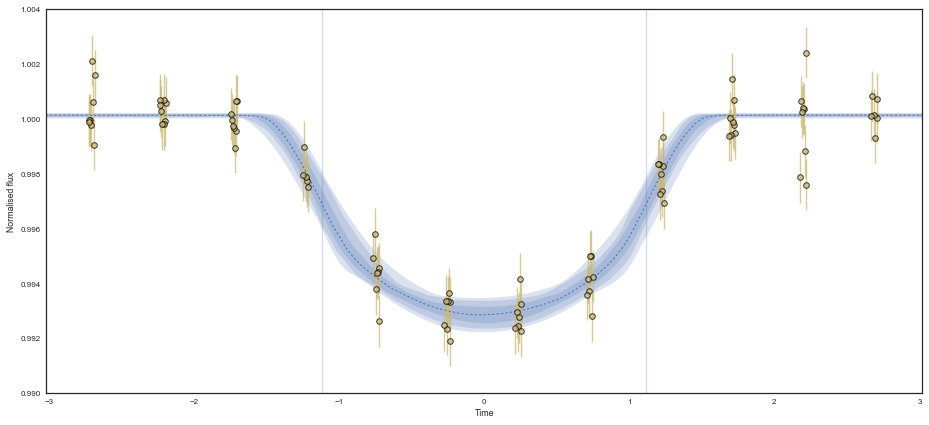

In [11]:
with sb.axes_style('white'):
    fig, ax = subplots(1,1, figsize=(13,6))
    hT14 = 0.5*median(df.T14)
    cp = sb.color_palette()
    sids = argsort(mphase_m_d)
    ax.errorbar(mphase_o_d, lpf.flux, mp[9], fmt='o', c=cp[4], alpha=0.75, markeredgecolor='k', markeredgewidth=1)
    [ax.fill_between(mphase_m_d[sids],*flux_pc[i:i+2,sids],alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
    ax.plot(mphase_m_d[sids], flux_pc[0,sids], c=cp[0], lw=1, ls=':')
    [ax.axvline(c*hT14, alpha=0.25) for c in [-1,1]]
    setp(ax, xlim=(-3.02,3.02), ylim=(0.99,1.004),xlabel='Time', ylabel='Normalised flux')
    fig.tight_layout()
    fig.savefig('../plots/lc_model_wn_b.pdf')

---

<center> &copy; 2017 Hannu Parviainen</center>